# SQRA with Lennar Jones Clusters - Convergence analysis

## The Setup
We start with a (1) simulation of a trajectory of the Lennard Jones cluster dynamics for 3 Particles in 2-Space.
The resulting points will be used for a subsampling procedure to obtain the cells for the SQRA.
There are two options:
- The Picking algorith: \
	Pick iteratively the point farthest from all previously picked points. For the adjacency matrix required for the SQRA we use a heuristic to match an expected average number of neighbours by a distance threshold. The Volumes and Areas of the cells are assumed to be uniform.

- Sparse Boxes: \
	We cover the trajectory with a grid of regular boxes. In this regime the adjacency is clear and volumes and areas are constant.
	For the estimation of the (assumedly constant) potential in each box we use the minimum of the correspoding samples.

### Postprocessing of the SQRA:
In order to obtain a 'nice' generator matrix we prune states with outbound rates above a certain thresholds and afterwards (unconnected) states without incoming rates.

## Committor computation
Based on the relative angles of the 3 particles we classify the states into the states: right oriented, left oriented, unoriented.
We then compute the committor function between the left and right orientations.

## Convergence analysis
In order to analyse the convergence of the SQRA we compute the committors for different levels of the sparse box discretization.
We then compute the distances of the committors (of different resolutions) with the finest committor.

For the distance we use the MSE on the support of the finest discretization.

In [1]:
using Revise
using Sqra
using Plots
using Arpack
using LinearAlgebra, Random
plotly(fmt=:png)

┌ Info: Precompiling Sqra [561b40b7-a0ab-4084-b14c-be45599a2ca9]
└ @ Base loading.jl:1342


Plots.PlotlyBackend()

# Simulation

We start by simulation a long trajectory to explore the state space.
We use these samples as a basis for either subsampling with the picking algorithm (`:voronoi`)
or for selecting the sparse boxes for a given discretization level (`ncells` in each direction)

In [2]:
#Random.seed!(0)
sim = Sqra.run(Sqra.Simulation(nsteps=2_000_000, sigma=.5, maxdelta=0.1))

Euler Maruyama simulation100%|██████████████████████████| Time: 0:00:09


Sqra.Simulation
  x0: Array{Float64}((6,)) [0.19920158482463968, 0.13789462153196408, -0.1709575705426315, 0.0784533378749835, 0.06778720715969005, -0.2112155752270007]
  epsilon: Int64 1
  r0: Float64 0.3333333333333333
  harm: Int64 1
  sigma: Float64 0.5
  dt: Float64 0.001
  nsteps: Int64 2000000
  maxdelta: Float64 0.1
  x: Array{Float64}((6, 2000001)) [0.19920158482463968 0.1960582663525417 … -0.034516353898452076 -0.06834158849652497; 0.13789462153196408 0.15069589376808779 … 0.012819453723856504 0.0010553032909447618; … ; 0.06778720715969005 0.07921192330857665 … 0.2851654976472091 0.3234377229799269; -0.2112155752270007 -0.2258592715456629 … -0.12482279803208124 -0.1357251750844212]
  u: Array{Float64}((2000001,)) [-2.855863452445878, -2.7372312931233402, -2.806526439543766, -2.7160024875762283, -2.8056027144974722, -2.7711269416899476, -2.489072400405498, -2.4657713416771125, -2.624679075545913, -2.5617499161890094  …  -2.4085584099955035, -1.9639402247319646, -2.373604891970

In [3]:
r = Sqra.discretize(Sqra.SpBoxDiscretisation(ncells=5, prune=Inf), sim)

sparse box picking100%|█████████████████████████████████| Time: 0:00:01


length(picks) = 2662
  2.665916 seconds (9.23 M allocations: 1.055 GiB, 17.41% gc time, 32.70% compilation time)
  0.095690 seconds (113.91 k allocations: 8.516 MiB, 98.31% compilation time)
sparsity: 2662/15625=0.170368
pruned 0 large outbound rates / unconnecteds
pruned 0 states without incoming rates


Sqra.SpBoxDiscretisation
  prune: Float64 Inf
  ncells: Int64 5
  boundary: Array{Float64}((6, 2)) [-0.8 0.8; -0.8 0.8; … ; -0.8 0.8; -0.8 0.8]
  Q: SparseArrays.SparseMatrixCSC{Float64, Int64}
  inds: Array{Int64}((2662,)) [1592125, 115512, 1213895, 615277, 1264589, 1528549, 1591756, 390892, 962756, 1996928  …  1664328, 1529182, 722195, 1603664, 1695795, 382869, 1786496, 803818, 1690911, 2145]
  picks: Array{Float64}((6, 2662)) [-0.028494945731581182 0.4863240362981244 … -0.4875491784629799 0.4911668682672852; -0.5086551777631446 -0.3699000900101297 … -0.3389095765291938 -0.16335147096696095; … ; 0.13192035296675575 0.14065022972938346 … -0.15234308304643426 0.28712990045052666; -0.16528171933187766 -0.18365051551435715 … -0.17941693677941303 -0.4871259603100428]
  u: Array{Float64}((2662,)) [-2.5874874710969586, -1.9961339300352865, -2.2803016750303193, -1.2699006767355616, -2.030515732957678, -1.8335313792552468, -1.5480290673322248, -2.852339941080733, -1.6146867122944801, -2.23004

In [22]:
#method = :voronoi
method = :sb

steps = 2_000_000
sigma=.5

ncells=6
npicks=300

prune=10000

Random.seed!(0)
@time r=Sqra.run(nsteps=steps, method=method, ncells=ncells, npicks=npicks, prune=prune, sigma=sigma, x0=Sqra.x0gen);

LoadError: UndefVarError: simulate not defined

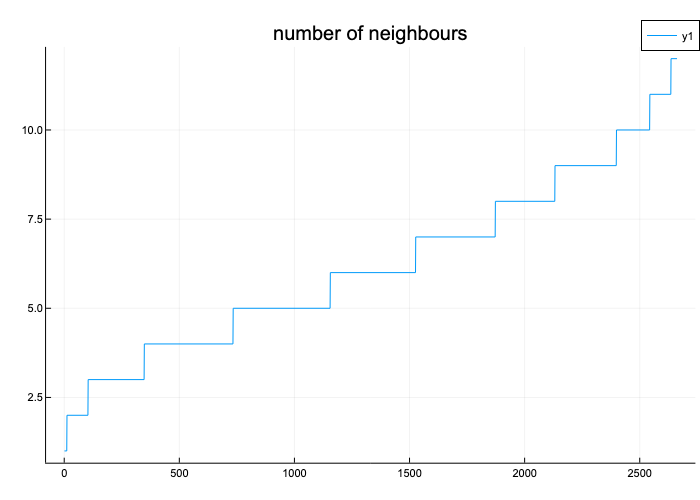

In [4]:
plot(sum(r.Q .> 0, dims=1)|>vec|>sort, title="number of neighbours")

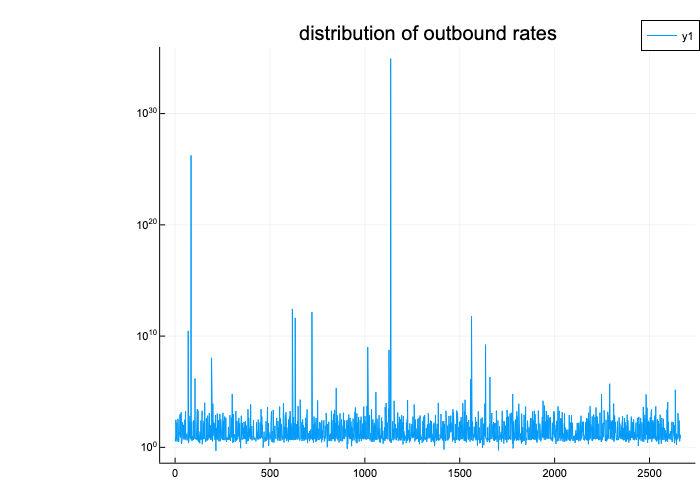

In [5]:
plot(-diag(r.Q), yaxis=:log, title="distribution of outbound rates")

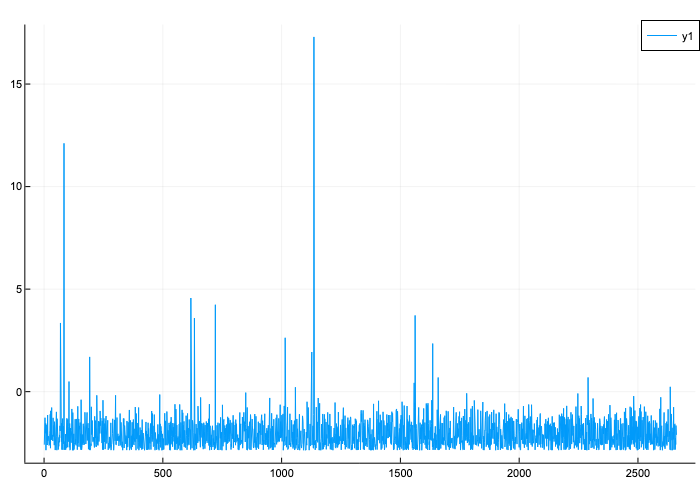

In [6]:
plot(r.u)

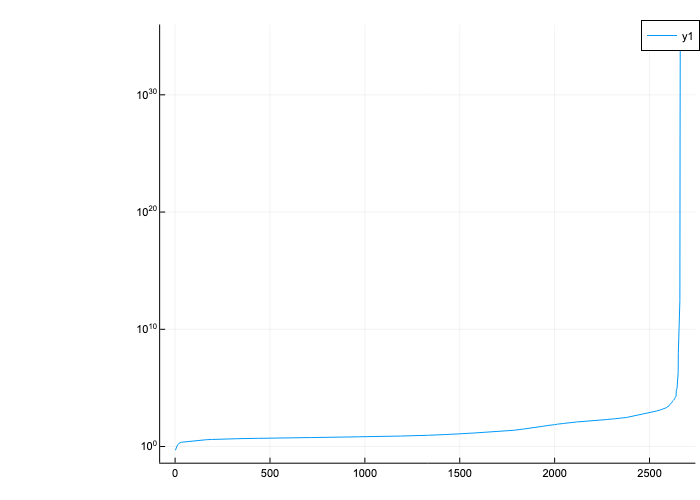

In [7]:
plot((sort(-diag(r.Q))), yaxis=:log)

In [59]:
println("size of system")
length(r.Q.nzval), size(r.Q)

size of system


(418613, (55381, 55381))

# Analysis of committor solver convergence

We compare different solvers for the linear system, as well as the solutions of a more pruned system.
Pruning is mainly there to enable solution of the linear committor system.
On the other hand iterative solvers might maybe help to compute ill conditioned systems?
After all the large outbound rates should not play a role in the computation.
We might as well try preconditioning with the diagonal rates!

In [60]:
cl = Sqra.classify(r.picks);

In [61]:
instances(Sqra.CommittorSolver)

(Sqra.direct, Sqra.lsqr, Sqra.lsmr, Sqra.gmres, Sqra.idrs)

In [111]:
# the whole system
cs1 = [@time Sqra.committor(r, method) for method in instances(Sqra.CommittorSolver)[1:end]];

Could not solve the committor system directly: SingularException(0)
Committor residual: NaN
  0.528644 seconds (203.83 k allocations: 74.643 MiB)
Committor residual: 11.897608407861465
  0.884110 seconds (211.86 k allocations: 192.608 MiB, 6.94% gc time)
Committor residual: 12.850096089332608
  0.837747 seconds (208.85 k allocations: 103.927 MiB)
Committor residual: 2.7470514010354434
  0.462286 seconds (203.90 k allocations: 16.735 MiB)
Committor residual: 7.744286130573262e-7
  0.408969 seconds (207.44 k allocations: 17.772 MiB)


In [82]:
function err(Q, c, x)
	A, b = Sqra.committor_system(Q, c)
	sum(abs2, A*x - b)
end

map(x->err(r.Q, cl, x), cs1)

5-element Vector{Float64}:
  NaN
 6976.724905722536
 8495.295535237541
 8540.495895103486
   24.909760963126693

In [83]:
Sqra.committor(r, Sqra.idrs, 10000)

Committor residual: 0.019484299541376558


55381-element Vector{Float64}:
 0.9141526032867159
 0.4753613200089016
 0.8249124477365939
 0.0
 0.9398459567842787
 0.0
 0.9996076780507395
 0.977402748051013
 0.0
 0.3895341921391344
 0.0021648940788383895
 0.00483932871376662
 0.9999999920508902
 ⋮
 0.9999999920508902
 0.7170966081906117
 0.0
 0.9478512640508281
 3.875109541014287e-5
 0.7716518357923218
 0.0
 0.9999999920508902
 0.0001359150200466771
 0.9675572799494644
 0.17816359684511646
 0.9997603246830207

In [48]:
# subprune the syste

_, pinds = Sqra.prune_Q(r.Q, 100)

QQ = r.Q[pinds, pinds]
cc = cl[pinds]

cs2 = [Sqra.solve_committor(QQ, bb, method) for method in instances(Sqra.CommittorSolver)]

map(x->err(QQ, cc, x), cs2)

pruned 3946 large outbound rates
pruned 164 states without incoming rates


5-element Vector{Float64}:
 1.405384680713981e-26
 1.1149265459909572e-5
 0.022643931944129024
 2.3786975722688237e-13
 8.633292159663264e-14

In [50]:
function mixederror(x)
	big = zeros(size(r.Q, 1))
	big[pinds] = x
	err(r.Q, cl, BigFloat.(big))
end

map(mixederror, cs2)

5-element Vector{BigFloat}:
 5.63307138766670692149324827443091343003361354641477563352922310919483404651566e+09
 5.633036387436833663349600265153851607988112370230071762266903849232319216640106e+09
 5.632314736972760711339969460695267200537347167545178490329861772598263175482572e+09
 5.633071315461920431241196854114507212724395219614553563165578285760805480532778e+09
 5.633071388725331647212967157523152640268071565466587049651195522732180922860143e+09

# Taking a look at committor solution

In [51]:
# select a solution from above as committor
c = cs1[5];

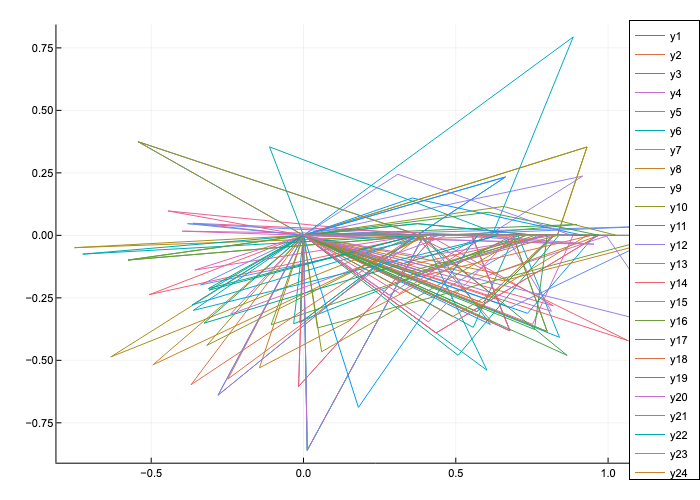

In [52]:
# plot states with a committor value in the defined range
transind = rand(findall((0.1 .<c.<0.2)), 100)
plot()
Sqra.plot_triangles!(Sqra.normalform(r.picks[:, transind]))

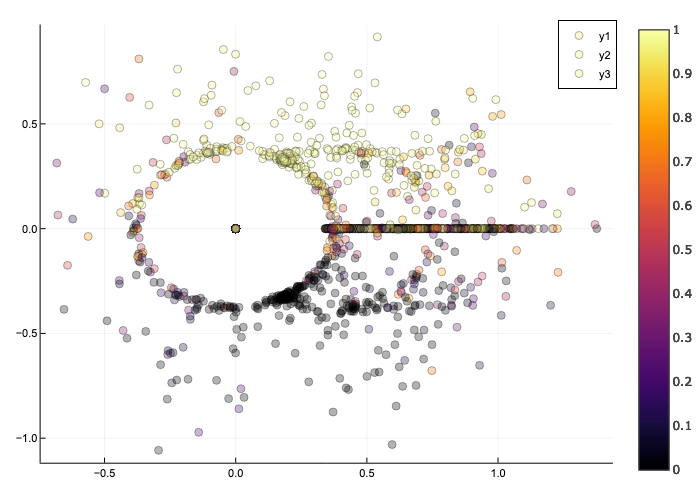

  5.580058 seconds (6.04 M allocations: 367.182 MiB, 1.65% gc time, 6.49% compilation time)


In [53]:
# plot the rotated and translated normal form of the LJ clusters and color by committor

plot()
plotint = 1:10:size(r.picks,2)
color = c
let points = r.picks[:, plotint], col = c[plotint]
#let points = r.picks[:, pinds], col = x
	@time Sqra.plot_trajectories(Sqra.normalform(points), alpha=0.3, marker_z=col) |> display;
end 

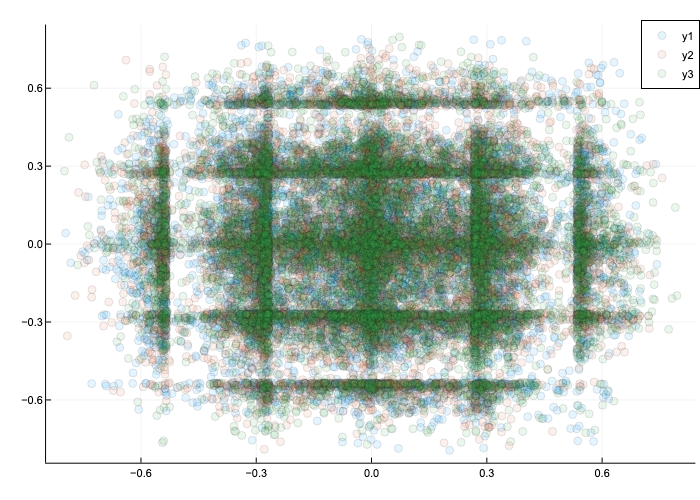

  3.258232 seconds (640.81 k allocations: 55.025 MiB, 3.01% compilation time)


In [54]:
# plot the JL cluster states in original coordinates
plot();
@time Sqra.plot_trajectories(r.picks, alpha=0.1) |> display;
#plot_trajectories(r.x[:,1:end], alpha=0.01, markersize=0.5)

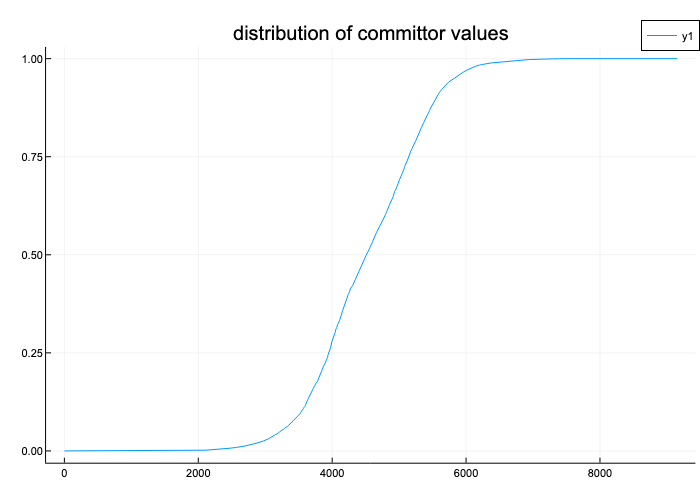

In [55]:
plot(c|>sort, title="distribution of committor values")

# Convergence of committors


In [246]:
runs = []

let x = r.x, 
	u = mapslices(r.x, dims=1) do x
		Sqra.lennard_jones_harmonic(x, epsilon=r.epsilon, sigma=r.r0, harm=r.harm) 
	end |> vec,
	beta = r.beta, 
	boundary = r.boundary,
	prune = r.prune

	for ncells in 3:6
		Q, inds = Sqra.sqra_sparse_boxes(x, u, ncells, beta, boundary)

		Q, pinds = Sqra.prune_Q(Q, prune)
		inds = inds[pinds]
		picks = x[:, inds]
		carts = Sqra.cartesiancoords(picks, ncells, boundary)

		classes = Sqra.classify(picks)
		c = Sqra.solve_committor(Q, classes, Sqra.idrs)

		push!(runs, (carts = carts, c=c))
	end

end

LoadError: type NamedTuple has no field epsilon

In [249]:
r

(neigh = 18, cartesians = [3 6 … 1 1; 1 2 … 6 3; … ; 5 5 … 3 5; 4 5 … 3 2], c = nothing, npicks = 300, classes = [-1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -1.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], method = :sb, boundary = [-0.8 0.8; -0.8 0.8; … ; -0.8 0.8; -0.8 0.8], sigma = 0.5, ncells = 6, x = [0.19920158482463968 0.20938030651221284 … -0.17194296689212948 -0.16781133684377658; 0.13789462153196408 0.15121847849641643 … -0.04299400053171757 -0.030595285050176623; … ; 0.06778720715969005 0.07632941907589609 … 0.2674587215843169 0.2946763636202318; -0.2112155752270007 -0.20618413722322274 … 0.00885528488961107 0.013054044888036888], picks = [-0.00938365766359332 0.5644878056019053 … -0.6836825529100713 -0.5890321549930826; -0.5762941165442956 -0.295909354917386 … 0.5427057685322156 -0.09502307443758673; … ; 0.2681914077971146 0.5074178554775775 … -0.05549737697522243 0.3123464224729521; 0.0010537669982941108 0.42761722693339244 … -0.10018270280187067 -0.275763935

In [241]:
fine = runs[end]

map(runs) do run
	Sqra.sp_mse(run.c, fine.c, run.carts, fine.cartesians, run.r.ncells,  fine.r.ncells)
end


LoadError: type NamedTuple has no field cartesians

LoadError: syntax: unexpected semicolon in array expression around In[212]:1

In [215]:
Sqra.sp_mse([1],[2], ones(1,1), ones(1,1)*2, 1, 3)

0.33333333333333326

In [201]:
runs[1].r.cartesians

6×673 Matrix{Int64}:
 1  1  2  2  3  3  2  3  3  1  1  3  1  …  1  1  1  1  1  2  2  2  3  1  3  3
 2  3  2  3  1  3  2  3  2  1  2  3  3     2  3  1  3  1  3  1  1  1  2  1  1
 1  1  1  1  1  3  2  1  3  2  3  2  2     2  1  3  2  2  2  1  2  2  1  3  2
 2  2  3  1  2  2  2  3  3  1  3  3  1     1  3  2  2  1  3  2  3  1  3  2  2
 2  1  1  3  1  1  2  3  3  1  1  1  2     3  1  1  2  3  3  2  3  3  3  2  3
 3  3  2  3  3  2  1  2  3  2  3  2  1  …  3  2  3  1  1  2  1  3  1  2  3  2

In [217]:
let run = runs[end]
Sqra.sp_mse(run.c, fine.c, run.r.cartesians, fine.r.cartesians, run.r.ncells,  fine.r.ncells)
end

LoadError: BoundsError: attempt to access 11826-element Vector{Float64} at index [12259]

# Convergence of picking, Part 1
We analyse how the number of boxes increases with growing sample size and resolution

In [251]:
]add Parameters

   Resolving package versions...
    Updating `~/Documents/code/sqra.jl/notebooks/Project.toml`
  [d96e819e] + Parameters v0.12.2
  No Changes to `~/Documents/code/sqra.jl/notebooks/Manifest.toml`
Precompiling project...
  ✓ SparseMatricesCSR
  ✓ GR_jll
  ✓ GR
  ✓ Plots
  ✗ Sqra
  4 dependencies successfully precompiled in 49 seconds (151 already precompiled)
  2 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions
  1 dependency errored. To see a full report either run `import Pkg; Pkg.precompile()` or load the package


sparse box picking100%|█████████████████████████████████| Time: 0:00:04


length(picks) = 713


sparse box picking100%|█████████████████████████████████| Time: 0:00:04


length(picks) = 3204


sparse box picking100%|█████████████████████████████████| Time: 0:00:04


length(picks) = 9194


sparse box picking100%|█████████████████████████████████| Time: 0:00:04
collecting neighbours100%|██████████████████████████████| Time: 0:00:00


length(picks) = 20183


sparse box picking100%|█████████████████████████████████| Time: 0:00:04
collecting neighbours100%|██████████████████████████████| Time: 0:00:05


length(picks) = 69151


sparse box picking100%|█████████████████████████████████| Time: 0:00:04
collecting neighbours100%|██████████████████████████████| Time: 0:00:27


length(picks) = 160135


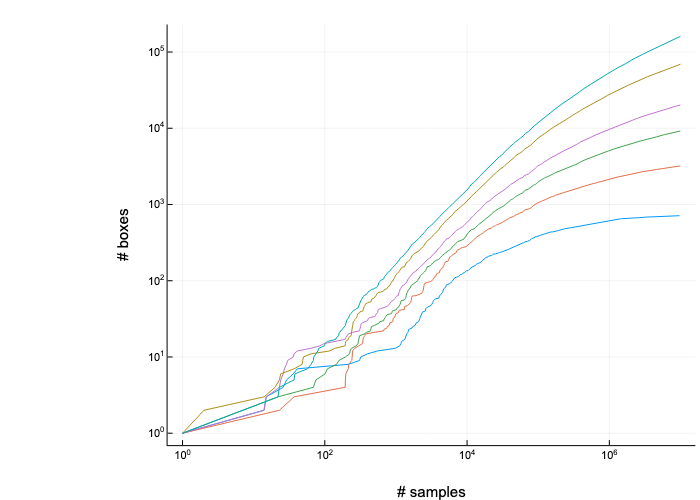

In [21]:
plot()
for n in [3,4,5,6,8,10]
    _, _, order = Sqra.sparseboxpick(r.x, n, ones(size(r.x,2)), r.boundary)
    plot!(order, 1:length(order), )
    accel =  (order[end]-order[end-10]) / 10
    #println(" $(length(order)/size(r.x, 2)  / accel * 100) % verbesserung pro prozent ")
end
plot!(legend=false, xlabel="# samples", ylabel="# boxes", yaxis=:log, xaxis=:log)

# --- OLD SNIPPETS --- #

# Generator preprocessing

In [9]:
cutoff = 3
prune = Inf

Q, pinds = Sqra.prune_Q(r.Q,Inf)

Q.nzval[Q.nzval.>cutoff] .= cutoff
Q = Sqra.fixdiagonal(Q)

pruned 0 large outbound rates
pruned 0 states without incoming rates


12541×12541 SparseArrays.SparseMatrixCSC{Float64, Int64} with 99367 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣏⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿

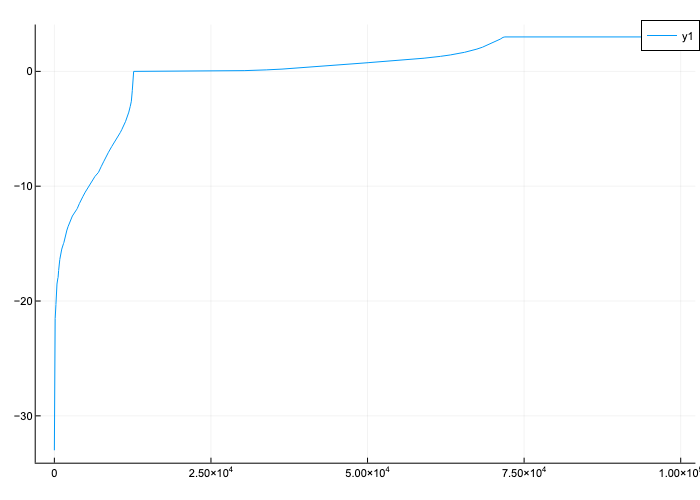

In [10]:
plot((Q.nzval|>sort))

# Committor convergence

In [11]:
Sqra.solve_committor(Q, r.classes[pinds])

LoadError: SingularException(0)

# Spectrum

In [12]:
@time evals, evecs = eigs(Q, which=:LR, maxiter=10000, tol=10)

  2.087857 seconds (4.48 M allocations: 273.488 MiB, 19.26% gc time, 99.05% compilation time)


(ComplexF64[-0.1475671764122306 + 0.0im, -0.7966261258484162 + 0.0im, -1.8944664837860472 + 0.0im, -3.2074719257932913 + 0.0im, -4.4945711114892735 + 0.0im, -6.043124274587199 + 0.0im], ComplexF64[-0.010705250976983669 + 0.0im 0.005518016661157727 + 0.0im … -0.0028558517423887216 + 0.0im 0.0034931182286626673 + 0.0im; -0.013898116354586501 + 0.0im 0.014670317939690276 + 0.0im … 0.002544949149689466 + 0.0im 0.0038144768680137583 + 0.0im; … ; -0.006333613260688547 + 0.0im 0.0045137213484804165 + 0.0im … -0.01626068251582685 + 0.0im -0.002602216051200564 + 0.0im; -0.0081162657879794 + 0.0im 0.001858681185873747 + 0.0im … -0.006749717318176673 + 0.0im 4.865746648047894e-5 + 0.0im], 6, 1, 20, [0.028421907389718715, -0.06938841874877381, -0.1473804498062421, -0.0828561532112862, -0.01905168086002779, 0.0635233506375137, -0.012358328049129638, 0.0400340581663493, -0.008171478918241487, 0.012414471024498887  …  0.015843549068211803, 0.04284768069297001, 0.026374072595923958, 0.0204594852064038

In [13]:
evals

6-element Vector{ComplexF64}:
 -0.1475671764122306 + 0.0im
 -0.7966261258484162 + 0.0im
 -1.8944664837860472 + 0.0im
 -3.2074719257932913 + 0.0im
 -4.4945711114892735 + 0.0im
  -6.043124274587199 + 0.0im

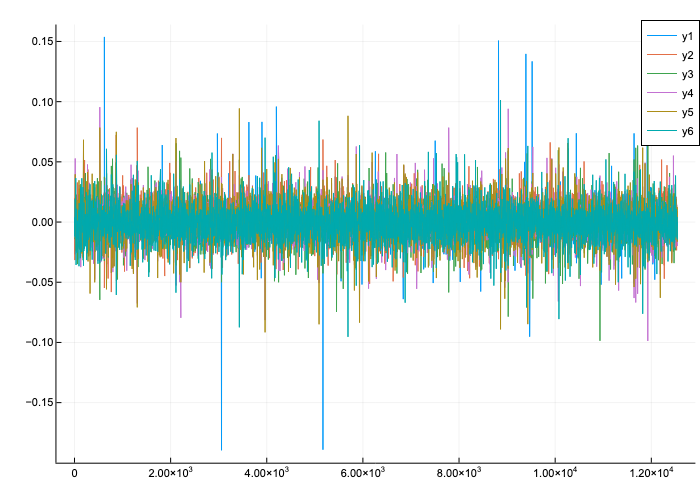

In [14]:
plot(evecs[:,:].|>real)
#plot!(r.classes, alpha=0.5)

# Cell analysis

In [15]:
prob = argmin(diag(r.Q))

5497

In [16]:
@show r.Q[prob,:]
neighs = r.Q[prob,:].nzind;

r.Q[prob, :] =   [416  ]  =  2.85995e291
  [4626 ]  =  3.54671e291
  [4845 ]  =  1.22278e289
  [5497 ]  =  -1.24125e292
  [5541 ]  =  2.51031e291
  [6510 ]  =  5.78385e289
  [10105]  =  3.37218e291
  [11683]  =  5.32815e289


In [17]:
@show r.us[prob]
r.us[neighs]

r.us[prob] = 165.02666398119146


8-element Vector{Float64}:
  -2.7491025397060844
  -2.802906371254066
  -1.385390370968821
 165.02666398119146
  -2.7165030890058035
  -1.7738762209598666
  -2.7902916316770408
  -1.753360044275069

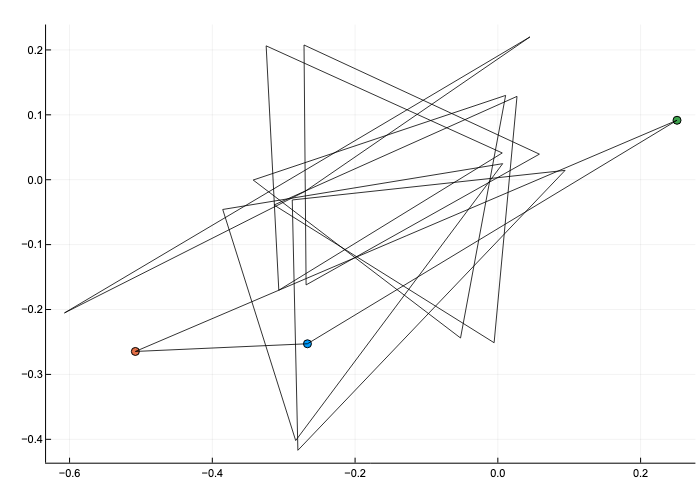

In [18]:
plot(); Sqra.plot_trajectories(r.picks[:,prob])
Sqra.plot_triangles!(r.picks[:, neighs], color=:black, alpha=0.8, legend=false)

# Spectrum again

In [19]:
evals, evecs = eigs(r.Q, which=:SM, nev=6)#, check=0, maxiter=1000, tol=0)
evecs = real.(evecs)
evals

LoadError: SingularException(0)

In [20]:
evecs

12541×6 Matrix{ComplexF64}:
   -0.0107053+0.0im   0.00551802+0.0im  …   0.00349312+0.0im
   -0.0138981+0.0im    0.0146703+0.0im      0.00381448+0.0im
  -0.00307447+0.0im    0.0039833+0.0im      -0.0106567+0.0im
  -0.00955884+0.0im   0.00317276+0.0im      0.00738616+0.0im
  -0.00545934+0.0im   0.00876829+0.0im      -0.0120584+0.0im
   0.00705766+0.0im    0.0200365+0.0im  …  -0.00422746+0.0im
   -0.0267979+0.0im   -0.0315819+0.0im      0.00381682+0.0im
   0.00276322+0.0im   0.00588531+0.0im      0.00104372+0.0im
  -0.00595206+0.0im   0.00290616+0.0im      0.00480697+0.0im
  -0.00392029+0.0im    0.0111989+0.0im     -0.00169179+0.0im
  -0.00501349+0.0im   0.00316529+0.0im  …  -0.00280449+0.0im
  -0.00598821+0.0im   0.00300475+0.0im     -0.00490362+0.0im
   -0.0111979+0.0im   0.00446742+0.0im       0.0188605+0.0im
             ⋮                          ⋱             ⋮
  -0.00821513+0.0im    0.0102204+0.0im     -0.00967229+0.0im
   -0.0058193+0.0im  -4.95268e-5+0.0im  …  -5.47581e-5+0.0im
 

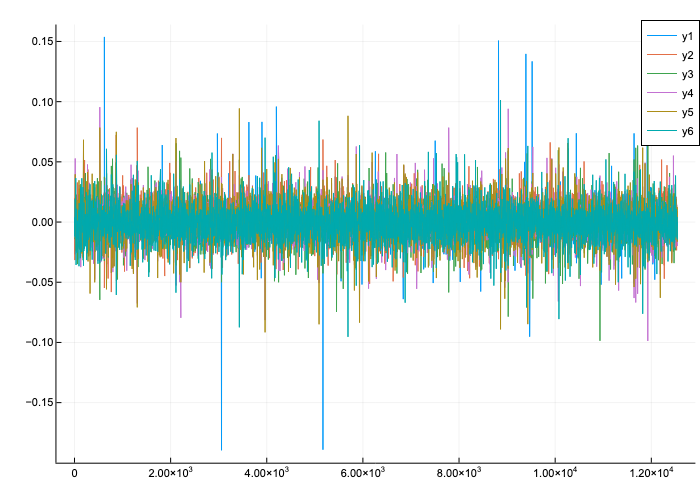

In [21]:
plot(real.(evecs))

In [22]:
step=100
for evec in 1:length(evals)

    col = real.(evecs[:,evec])[1:step:end]
    data = center[:,1:step:end]
    plot();
    plot_trajectories(normalform(data), alpha=0.3, marker_z=col, clims=(-1,1).*std(col), seriescolor=:bwr) |> display

    scatter(data[1,:], data[2,:], alpha=0.3, marker_z=col, clims=(-1,1).*std(col), seriescolor=:bwr) |> display
end

LoadError: MethodError: no method matching axes(::typeof(center), ::Int64)
[0mClosest candidates are:
[0m  axes([91m::RecipesPipeline.Volume[39m, ::Any...) at /Users/alex/.julia/packages/RecipesPipeline/a80Nu/src/utils.jl:108
[0m  axes([91m::Base.Broadcast.Broadcasted{var"#s832", var"#s831", F, Args} where {var"#s832", var"#s831"<:(Tuple{Vararg{T, N}} where T), F, Args<:Tuple}[39m, ::Integer) where N at broadcast.jl:212
[0m  axes([91m::Number[39m, ::Integer) at number.jl:81
[0m  ...